In [5]:
# !pip install import-ipynb

In [12]:
# import import_ipynb


In [8]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as implied_vol

In [153]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import math

In [244]:
# for typization

from typing import *

In [381]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

def delta_BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def delta_BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

    

def merton_jump_call(S, K, T, r, sigma, m , v, lam):
    p = 0
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact))  * BS_CALL(S, K, T, r_k, sigma_k)
    
    return p 


def merton_jump_put(S, K, T, r, sigma, m , v, lam):
    p = 0 # price of option
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k) # 
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) \
                    * BS_PUT(S, K, T, r_k, sigma_k)
    return p 

$\frac{dS}{S} = \mu dt\:+\:\sigma dW_t\:+Jump ~~~~~~~~~~~~~~~~~(1) \\$
$S_0^{(n)} = S_0e^{(-\lambda k + n\mu_y + \frac{n\sigma^2_y}{2})} \\ \\ $
$ \\ \\ Jump = \begin{cases} 
Arrival - Poisson\\
Size - Lognormal
\end{cases} $

$C(S_0^{(n)}, T) = \sum^{M}_{n=0}C(S_0^{(n)},T\:|\: N_t = n)\cdot \frac{(\lambda T)^n}{n!}\cdot e^{-\lambda T} \\$
$M$ = 20 (empirically)

$C(S_0^{(n)}, T) = S_0^{(n)}N[d_1] - Ke^{-rT}N[d_2]$

### At the moment $t_1$ user sets up an option replication (S=1000, K=1100, T=7days=0.019yrs, amount=2 eth)
### Suppose there will be 7 hedges

In [200]:
def mc_paths(S0, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z)

    # PV is extected discounted payoff
#     C = np.sum(m.exp(-r * T) * np.maximum(S[-1] - K, 0)) / I
    return S

In [231]:
SPaths = mc_paths(1000, 0.02, 0, 0.9, 10, 1)


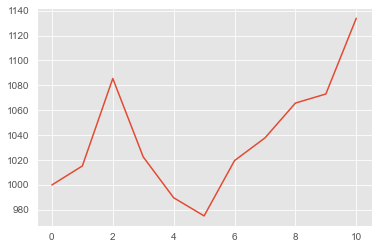

In [232]:
# plt.figure(figsize=(15,8))
plt.plot(SPaths)
plt.grid(True)


In [239]:
# t1
S = SPaths
K = 1100
T = 0.02
sigma = 0.5
r = 0

# initial portfolio consists of 2500 USDC

eth = 0
usdc = 2500

prev_delta=0

for i in range(len(S)-1):
    eth += (delta_BS_CALL(S[i][0], K, T*(1-i/len(S)), r, sigma)-prev_delta)
    usdc -= (delta_BS_CALL(S[i][0], K, T*(1-i/len(S)), r, sigma)-prev_delta)* S[i][0]
    prev_delta = delta_BS_CALL(S[i][0], K, T*(1-i/len(S)), r, sigma) 
    print(eth, usdc, 'total value:', eth*S[i][0] + usdc)
    print('---------')

print('BS payoff:', S[-2][0]-K-BS_CALL(S[0][0], K, T, 0, 0.2))

0.09466998568404417 2405.330014315956 total value: 2500.0
---------
0.12398936570184166 2375.563094377064 total value: 2501.4450714134246
---------
0.4305617144712701 2042.7673144871749 total value: 2510.1581999775067
---------
0.1188015766333016 2361.5498574473295 total value: 2483.0274426494593
---------
0.03255479309596622 2446.9107380102732 total value: 2479.131137325375
---------
0.011267301511411618 2467.668757078967 total value: 2478.655812960943
---------
0.058371328070636885 2419.6422765917955 total value: 2479.156709929463
---------
0.0894844563979067 2387.3533188684287 total value: 2480.2195777395436
---------
0.20119744644127008 2268.291827564628 total value: 2482.72407944971
---------
0.2098524930455491 2259.0043382729214 total value: 2484.191199893621
---------
BS payoff: -26.930760806152776


N = norm.cdf

print(N(0.5))
print(N(0.6))
print(N(2))

In [550]:
# Smart contract initial state

models = ['BS', 'merton'] # merton equals to jump diffusion
pairs = ['ethusdc']


total_delta_eth_usdc_BS = 0
eth_usdc_BS = {} # positions
eth_usdc_BS_deltas = []


total_delta_eth_usdc_merton = 0
eth_usdc_merton = {} # positions
eth_usdc_merton_deltas = []

def GetPositions(pair: str, model: str) -> list:
    if pair != 'ethusdc':
        return []
    
    if model == 'BS':
        return eth_usdc_BS
    
    if model == 'merton':
        return eth_usdc_merton

# add new request to replicate option. 
# Inputs: long/short, pair, maturiry, strike, amount, model, type (call/put/etc), model parameters, 
def AddNewPosition(isLong: bool, pair: str, T: float, 
                   K: Union[int, float] , amount: Union[int, float], 
                   model: str, _type: str, model_params: list) -> bool:
    
    if model not in models:
        return False
    
    if pair not in pairs:
        return False
    
    if model == "BS" and pair == 'ethusdc':
        eth_usdc_BS[len(eth_usdc_BS.keys())] = [isLong, T, K, amount, _type, model_params]
    
    if model == "merton" and pair == 'ethusdc':
        eth_usdc_merton[len(eth_usdc_merton.keys())] = [isLong, T, K, amount, _type, model_params]
    
    return True



In [591]:
# Smart-contract initialization

import random

for i in range(500):
    model = random.choice(models)
    pair = random.choice(pairs)
    S = 1000 # initial ether price in usdc
    T = random.choice([x/100 for x in range(2, 30, 1)])   # random maturity from [0.02, 0.3]
    K = random.choice([x for x in range(700, 1300, 25)])  # random strike from [700, 1300], step 25
    isLong = random.choice([True, False]) # means either we replicate a buying option or selling
    amount = random.choice([x for x in range(1, 30, 1)])  # random amount from [1, 30], step 1
    _type = random.choice(['call', 'put'])
    r = 0

    if pair != 'ethusdc':
        break
    
    if model == 'BS':
        sigma = round(random.random(), 2) # random value between (0, 1)
        
        AddNewPosition(isLong, pair, T, K, amount, model, _type, [sigma, r])
    
    if model == "merton":
        m = 0 # meean of jump size
        v = random.choice([x / 10 for x in range(0, 5, 1)]) # standard deviation of jump, random from [0.0, 0.4]
        lam = random.choice([1, 2, 3, 4, 5]) # intensity of jump i.e. number of jumps per annum
        sigma = round(random.random(), 2) # random value between (0, 1)
        AddNewPosition(isLong, pair, T, K, amount, model, _type, [sigma, r, m, v, lam])
    

In [592]:
eth_usdc_BS

{0: [True, 0.08, 1050, 27, 'put', [0.65, 0]],
 1: [True, 0.18, 1050, 10, 'call', [0.43, 0]],
 2: [False, 0.03, 1175, 24, 'call', [0.52, 0]],
 3: [True, 0.19, 1025, 5, 'put', [0.72, 0]],
 4: [True, 0.22, 1200, 6, 'call', [0.82, 0]],
 5: [True, 0.1, 825, 15, 'call', [0.0, 0]],
 6: [True, 0.09, 800, 26, 'call', [0.18, 0]],
 7: [False, 0.04, 800, 28, 'call', [0.69, 0]],
 8: [False, 0.07, 700, 4, 'call', [0.67, 0]],
 9: [True, 0.03, 850, 18, 'call', [0.07, 0]],
 10: [True, 0.28, 775, 4, 'put', [0.09, 0]],
 11: [False, 0.17, 1275, 17, 'call', [0.94, 0]],
 12: [True, 0.2, 975, 11, 'put', [0.81, 0]],
 13: [True, 0.2, 800, 11, 'call', [0.01, 0]],
 14: [False, 0.17, 925, 2, 'put', [0.62, 0]],
 15: [True, 0.19, 700, 10, 'put', [0.39, 0]],
 16: [False, 0.2, 1150, 25, 'put', [0.63, 0]],
 17: [True, 0.02, 700, 2, 'call', [0.76, 0]],
 18: [True, 0.12, 1175, 22, 'call', [0.24, 0]],
 19: [True, 0.29, 950, 26, 'call', [0.38, 0]],
 20: [False, 0.23, 975, 20, 'call', [0.59, 0]],
 21: [False, 0.27, 1250, 2

In [642]:
# Imitation of the process of offchain computing

# At the moment t the node is going to compute all deltas for BS positions for the ethusdc pair

computed_deltas = {}


def OffchainComputing():

#     t = random.choice([x/100 for x in range(2, 15, 1)]) # interval is [0.01, 0.15]

    t = 0.01
    St = 1100

    current_positions_BS = GetPositions('ethusdc', 'BS')

    for position in current_positions_BS.keys():
        isLong, T, K, amount, _type, model_params = current_positions_BS[position] # unpacking
        sigma, r = model_params

        delta = 0

        if t >= T:
            computed_deltas[position] = 'closed'
            continue

        if _type == 'call':
            delta = delta_BS_CALL(St, K, T, r, sigma)

        elif _type == 'put':
            delta = delta_BS_PUT(St, K, T, r, sigma)

        if isLong == False:
            delta = -delta

        computed_deltas[position] = delta
    

# Now constructing a proof:


# def ProofConstructor(arr: list) -> list:
    


In [643]:
t

0.04

In [644]:
OffchainComputing()
computed_deltas

<ipython-input-381-529936b6d62f>:14: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-381-529936b6d62f>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-381-529936b6d62f>:18: RuntimeWarning:

divide by zero encountered in double_scalars



{0: -0.3650624434903158,
 1: 0.6354089843869334,
 2: -0.2459497707968079,
 3: -0.35125619514685724,
 4: 0.4864691589131504,
 5: 1.0,
 6: 0.9999999984317649,
 7: -0.9912643339307605,
 8: -0.9958350699330751,
 9: 1.0,
 10: -8.071321389024888e-14,
 11: -0.4257756477093626,
 12: -0.30358249373442237,
 13: 1.0,
 14: 0.21022757981111728,
 15: -0.0030368062389823924,
 16: 0.5067421992097872,
 17: 0.9999897340318256,
 18: 0.2260911347620404,
 19: 0.7935292414871841,
 20: -0.7149124171621398,
 21: -0.22901059589074696,
 22: 0.9998075698914615,
 23: -0.8633370185802729,
 24: -0.913389364629213,
 25: -0.25503309688055165,
 26: 0.28139155159545487,
 27: -0.2588825093022378,
 28: -0.3458943666093084,
 29: -0.8375615659334363,
 30: -0.9868155809938575,
 31: -0.005282582598454932,
 32: 0.6274187780370412,
 33: 0.9354987598589339,
 34: -0.9092873097870728,
 35: 0.5443144763846838,
 36: -0.0037263654443993044,
 37: 0.9703584177299415,
 38: -0.8635500210099569,
 39: 0.742765583679846,
 40: -0.1203371924

In [534]:
# arr = [0]*24 + [1, 1]
# random.shuffle(arr)
# print(arr)

In [533]:
# arr = [x+1 for x in range(27)]
# print(arr)
# len(arr)

In [532]:
# f = lambda x1,x2: sum([x+1 for x in range(x1, x2)])
# print([f(0,27), f(0, 9), f(9, 18), f(18, 27), f(0, 3), f(3, 6), f(6, 9), f(9, 12), f(12, 15), f(15, 18), f(18, 21), f(21, 24), f(24, 27)] + arr)

In [619]:
arr = [0]*500
len([0] * (3**(1*math.ceil(math.log(len(arr), 3))) - len(arr)))
math.log(729, 3)

6.0

In [633]:

def MakeTernaryTree(arr):
    new_arr = []
    # making the array size being the power of 3
    arr = arr + [0] * (3**(1*math.ceil(math.log(len(arr), 3))) - len(arr))
    
    
    
    for i in range(int(math.log(len(arr), 3)), -1, -1):
        for j in range(0, len(arr), 3**i):
            new_arr.append(sum(arr[j:j+3**i]))
            
#             if i == 3:
#                 new_arr.append(sum(arr[0 : len(arr)]))
#             if i == 2:
#                 new_arr.append(sum(arr[0 : len(arr) / 3 + 1]))
#                 new_arr.append(sum(arr[len(arr) / 3 : len(arr) * 2 / 3 + 1]))
#                 new_arr.append(sum(arr[len(arr) * 2 / 3 : len(arr)]))
            
#             print('i, j:', i, j)
            

    return new_arr

    

In [634]:

# print(MakeTernaryTree(arr))

In [639]:
# Let's suppose we have 2 lists, but the difference is in just 1 element:

import copy


arr1 = [x+1 for x in range(500)]

arr2 = copy.deepcopy(arr1)

# random.shuffle(arr)  # now both arrays are shuffled

arr2[52] = 9999
# print(arr1)
# print(arr2)

tree1 = MakeTernaryTree(arr1)
tree2 = MakeTernaryTree(arr2)


print(arr1[52], ',' , arr2[52])

53 , 9999


In [ ]:
# Now let's find this index for O(log3(len(arr)))

def ternary_search(tree1, tree2):
    i = 1
    j = 0
    while j < math.ceil(math.log(arr1)):
        
        if tree1[i] - tree2[i] != 0:
            i += 
            
            
        
        if tree1[i] - tree2[i] !== 0:
            i+=
        
        j+=1

        
    

In [687]:
delta1 = [N(x/100) for x in range(-10, 10, 1)]  # d1 = 1.3
delta2 =  [N(x/100) for x in range(-10, 10, 1)] # d1 = -0.5
print(delta1, delta2)

delta3 = N((1.3-0.5) / 2)
print(delta3)
_delta3 = (delta1+delta2)/2

print(delta3 / _delta3)


0.9031995154143897 0.3085375387259869
0.6554217416103242
1.0817887253192726


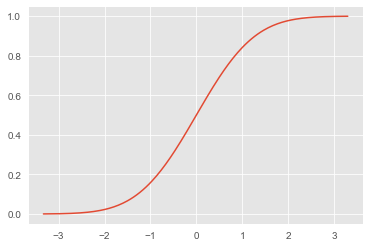

In [668]:
X = [x/30 for x in range(-100, 100,1)]
# Y = [math.log(1/(1+math.exp(-x))) for x in X]
Y = [(N(x)) for x in X]

plt.plot(X,Y)

In [157]:
import pandas as pd

def mean(arr):
    return sum(arr)/len(arr)

In [140]:
# https://data.binance.vision/?prefix=data/spot/monthly/klines/ETHUSDC/

df1 = pd.read_csv('../etc/ETHUSDC-1m-2022-04.csv')
df1.columns = ["Open time", "Open", "High", "Low", "Close", "Volume"," Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Take buy quote asset volume", "Ignore"]

df2 = pd.read_csv('../etc/ETHUSDC-1m-2022-05.csv')
df2.columns = ["Open time", "Open", "High", "Low", "Close", "Volume"," Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Take buy quote asset volume", "Ignore"]

df3 = pd.read_csv('../etc/ETHUSDC-1m-2022-06.csv')
df3.columns = ["Open time", "Open", "High", "Low", "Close", "Volume"," Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Take buy quote asset volume", "Ignore"]

dfs = [df1, df2, df3]



In [168]:
print('1min interval')
for (j, df) in enumerate(dfs):
    df['1min relative change'] = (df['High'] - df['Low']) / ((df['Open'] + df['Close']) / 2) * 100
    print('max relative deviation in %: df{}: {}, mean: {}'
          .format(j+1, round(max(df['1min relative change']), 3), round(mean(list(df['1min relative change'])), 3)))
    

1min interval
max relative deviation in %: df1: 3.583, mean: 0.083
max relative deviation in %: df2: 8.137, mean: 0.156
max relative deviation in %: df3: 5.838, mean: 0.2


In [170]:
# 10min relative change


print('10min interval')

for (j, df) in enumerate(dfs):
    opens = list(df['Open'])
    closes = list(df['Close'])
    highs = list(df['High'])
    lows = list(df['Low'])

    rel_change_10min = []

    for i in range(0, len(opens), 10):
        loc_low = min(lows[i:i+10])
        loc_high = max(highs[i:i+10])
        loc_open = opens[i]
        try:
            loc_close = closes[i+10]
        except Exception:
            loc_close = closes[-1]
    #     print(loc_low, loc_high, loc_open, loc_close)

        rel_change_10min.append((loc_high-loc_low)/((loc_open+loc_close)/2) * 100)


    print('max relative deviation in %: df{}: {}, mean: {}'
          .format(j+1, round(max(rel_change_10min), 3), round(mean(rel_change_10min), 3)))


10min interval
max relative deviation in %: df1: 3.645, mean: 0.345
max relative deviation in %: df2: 12.043, mean: 0.582
max relative deviation in %: df3: 9.881, mean: 0.737


[0.3571161324116472,
 0.7827879532184903,
 0.6225536553124572,
 0.7600725055615056,
 0.265476728422959,
 0.7133942466217713,
 0.21535866190484967,
 0.2276207211928797,
 0.44358761753917203,
 0.3500871362255335,
 0.21704692739728987,
 0.20213397933913313,
 0.36417300020347143,
 0.3010391789840653,
 0.3153505949011498,
 0.2053255340661969,
 0.23276082790440253,
 0.4943679761132933,
 0.4690833759537905,
 0.4227760916756615,
 0.3485854578227026,
 0.22810691993446403,
 0.22906776674475388,
 0.25093387322135935,
 1.0773916820784157,
 0.7573174825829967,
 0.28068537037758057,
 0.19327826888997224,
 0.29848348624566284,
 0.36962069875913567,
 0.29273338505301694,
 0.1697375536575065,
 0.2934931125048332,
 0.2544179151749949,
 0.49492494416530514,
 0.313484496766703,
 0.2908940333078788,
 0.2260015566697554,
 0.36831174071266726,
 0.2675903181896759,
 0.21545210065798517,
 0.15205192521526864,
 0.6674157013159803,
 0.4274643240655683,
 0.345696646018023,
 0.4901428549270223,
 0.5313998435236593

In [106]:
df2

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Take buy quote asset volume,Ignore
